In [1]:
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
lgcg_path = os.path.abspath(os.path.join('../lgcg'))
if lgcg_path not in sys.path:
    sys.path.append(lgcg_path)
from lib.measure import Measure
# from lgcg_stochastic import LGCG_stochastic
from lgcg import LGCG

# Generate Data and Define Functions

In [2]:
Omega = np.array([[0,1],[0,1]])
alpha = 0.1
observation_resolution = 4
observations = (np.array(np.meshgrid(
                    *(
                        np.linspace(bound[0], bound[1], observation_resolution+2)
                        for bound in Omega
                    ))
            ).reshape(len(Omega), -1).T)
observations = np.array([obs for obs in observations if all(obs!=0) and all(obs!=1)])
std_factor = 1
k = lambda x: np.array([np.exp(-np.linalg.norm(point-x)**2/std_factor)/np.sqrt(std_factor*np.pi)**Omega.shape[0] for point in observations])
true_sources = np.array([[0.1,0.3]])
true_weights = np.array([1])
u_bar = Measure(support=true_sources, coefficients=true_weights)
target = u_bar.duality_pairing(k)
norm_K_star = np.sqrt(len(observations)/(std_factor*np.pi)**Omega.shape[0])
norm_K_star_L = np.sqrt(0.5*std_factor*len(observations)/(np.pi*std_factor)**Omega.shape[0])

In [3]:
g = lambda u: alpha * np.linalg.norm(u, ord=1)
f = lambda u: 0.5 * np.linalg.norm(sum(c * k(x) for x, c in zip(u.support, u.coefficients)) - target) ** 2

In [4]:
def p_raw(u, k, target):
    def p_u(x):
        Ku = u.duality_pairing(k)
        inner = Ku-target
        return -np.dot(inner, k(x))
    return p_u

p = lambda u: p_raw(u, k=k, target=target)

In [5]:
def grad_k_raw(observations, std_factor):
    def grad_k(x):
        return np.array([2*(point-x)*np.exp(-np.linalg.norm(point-x)**2/std_factor)/(std_factor*np.sqrt(std_factor*np.pi)**Omega.shape[0]) for point in observations])
    return grad_k

grad_k = grad_k_raw(observations, std_factor) # The Jacobian of k, shape=(len(observations), Omega.shape[0])

In [6]:
def hess_k_raw(observations, std_factor):
    def hess_k(x):
        first_part = lambda point: -2*np.eye(Omega.shape[0])*np.exp(-np.linalg.norm(point-x)**2/std_factor)/(std_factor*np.sqrt(std_factor*np.pi)**Omega.shape[0])
        second_part = lambda point: 4*np.dot((point-x).reshape(-1,1), np.array([point-x]))*np.exp(-np.linalg.norm(point-x)**2/std_factor)/(std_factor**2*np.sqrt(std_factor*np.pi)**Omega.shape[0])
        return np.array([first_part(point)+second_part(point) for point in observations])
    return hess_k

hess_k = hess_k_raw(observations, std_factor) # The derivative of the Jacobian of k, shape=(len(observations), Omega.shape[0], Omega.shape[0])

In [7]:
def grad_P_raw(k, target, observations, std_factor):
    grad_k = grad_k_raw(observations, std_factor)
    def grad_P(x,u):
        p_u = p_raw(u, k, target)
        inner = target-u.duality_pairing(k)
        return np.sign(p_u(x))*np.matmul(grad_k(x).T, inner)
    return grad_P

grad_P = grad_P_raw(k, target, observations, std_factor)

In [8]:
def hess_P_raw(k, target, observations, std_factor):
    hess_k = hess_k_raw(observations, std_factor)
    def hess_P(x,u):
        p_u = p_raw(u, k, target)
        inner = target-u.duality_pairing(k)
        return np.sign(p_u(x))*np.tensordot(hess_k(x),inner,axes=([0,0]))
    return hess_P

hess_P = hess_P_raw(k, target, observations, std_factor)

In [9]:
def get_grad_j(k, grad_k, alpha, target):
    def grad_j(positions, coefs):
        to_return = []
        grad_F = (
            np.sum(
                np.array([c * k(x) for x, c in zip(positions, coefs)]),
                axis=0,
            )
            - target
        )
        for ind, x in enumerate(positions):
            # nabla_x_ind
            array = coefs[ind] * np.matmul(grad_k(x).T, grad_F)
            to_return += array.tolist()
        # nabla_u
        K = np.array([k(x) for x in positions])
        to_return += (np.dot(K, grad_F) + alpha * np.sign(coefs)).tolist()
        return np.array(to_return)
    return grad_j

grad_j = get_grad_j(k, grad_k, alpha, target)

In [10]:
def get_hess_j(k, grad_k, hess_k, target):
    def hess_j(positions, coefs):
        matrix_dimension = len(positions)*Omega.shape[0] + len(coefs)
        hesse_matrix = np.zeros((matrix_dimension, matrix_dimension))
        step = Omega.shape[0]
        coefs_delay = step*len(positions)
        inner = sum(k(x)*c for c, x in zip(coefs, positions))-target
        for i, position in enumerate(positions):
            # nabla_{x_i,x_j}
            for j, other_position in enumerate(positions):
                if j<i:
                    continue
                block = coefs[i]*coefs[j]*np.matmul(grad_k(position).T, grad_k(other_position))
                if i==j:
                    block += coefs[i]*np.tensordot(hess_k(position),inner,axes=([0,0]))
                hesse_matrix[i*step:(i+1)*step, j*step:(j+1)*step] = block
                hesse_matrix[j*step:(j+1)*step, i*step:(i+1)*step] = block.T
            # nabla_{x_i,u_j}
            for j, coef in enumerate(coefs):
                block = coefs[i]*np.matmul(grad_k(position).T, k(positions[j]))
                if i == j:
                    block += np.matmul(grad_k(position).T, inner)
                hesse_matrix[i*step:(i+1)*step, coefs_delay+j] = block
                hesse_matrix[coefs_delay+j, i*step:(i+1)*step] = block.T
        for i, coef in enumerate(coefs):
            # nabla_{u_i,u_j}
            for j, other_coef in enumerate(coefs):
                if j<i:
                    continue
                block = np.dot(k(positions[i]), k(positions[j]))
                hesse_matrix[coefs_delay+i,coefs_delay+j] = block
                hesse_matrix[coefs_delay+j,coefs_delay+i] = block
        return hesse_matrix
    return hess_j

hess_j = get_hess_j(k, grad_k, hess_k, target)

In [11]:
gamma = 0.5
theta = 1e-1
sigma = 5e-2
m = 1e-2
bar_m = 1e1
L = 1
R = 5e-2

# Test LGCG

In [12]:
exp = LGCG(target=target, 
           k=k, 
           g=g, 
           f=f,
           p=p,
           grad_P=grad_P,
           hess_P=hess_P,
           norm_K_star=norm_K_star,
           norm_K_star_L=norm_K_star_L,
           grad_j=grad_j,
           hess_j=hess_j,
           alpha=alpha,
           Omega=Omega,
           gamma=gamma,
           theta=theta,
           sigma=sigma,
           m=m,
           bar_m=bar_m,
           L=L,
           R=R
           )

In [15]:
support = [[0.13439718,0.31639137]]
coefs = [0.96376116]
u =Measure(support=support, coefficients=coefs)
print([p(u)(x) for x in support])
print(g(coefs)-u.duality_pairing(p(u)))

[0.009999995687565181]
4.1561571840348366e-09


In [13]:
u, P_values, objective_values = exp.solve_exact(tol=1e-12)

DEBUG:root:SSN in 1 dimensions converged in 4 iterations to tolerance 1.000E-12
INFO:root:1: P_value:3.061E-02, support: [[0.45903559 0.47938753]], coefs: [0.83110663], x: [0.         0.13305221]
DEBUG:root:SSN in 2 dimensions converged in 6 iterations to tolerance 1.000E-12
INFO:root:2: P_value:4.464E-03, support: [[0.         0.13305221]
 [0.45903559 0.47938753]], coefs: [0.73725528 0.30743963], x: [0.04100485 0.73406357]
DEBUG:root:SSN in 3 dimensions converged in 6 iterations to tolerance 1.000E-12
INFO:root:3: P_value:1.150E-03, support: [[0.         0.13305221]
 [0.04100485 0.73406357]
 [0.45903559 0.47938753]], coefs: [0.69194948 0.13716674 0.23135346], x: [0.16249789 0.41273316]
DEBUG:root:SSN in 4 dimensions converged in 15 iterations to tolerance 1.000E-12
INFO:root:4: P_value:9.269E-04, support: [[0.         0.13305221]
 [0.16249789 0.41273316]], coefs: [0.31764612 0.6736284 ], x: [0.29899428 0.1518932 ]
DEBUG:root:SSN in 3 dimensions converged in 6 iterations to tolerance 1

KeyboardInterrupt: 

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/vol/cs-hu/hnatiuar@hu-berlin.de/miniconda3/envs/conda_env_lgcg/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUni.ttf', name='STIXNonUnicode', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/vol/cs-hu/hnatiuar@hu-berlin.de/miniconda3/envs/conda_env_lgcg/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerifDisplay.ttf', name='DejaVu Serif Display', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager

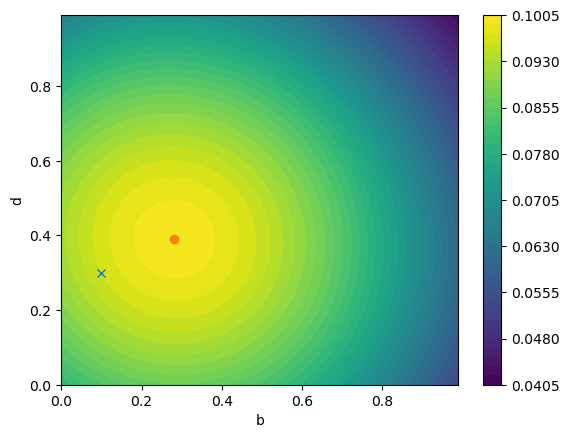

In [13]:
u_tilde = Measure(support=[[0.28197452,0.38970136]], coefficients=[0.80611134])
P = lambda x: np.abs(p(u_tilde)(x))
a = np.arange(0,1,0.01)
B, D = np.meshgrid(a,a)
vals = np.array([P(np.array([x_1,x_2])) for x_1, x_2 in zip(B.flatten(), D.flatten())]).reshape((100,100))

plt.contourf(B, D, vals, levels=50)
plt.colorbar()
plt.plot([0.1], [0.3], "x")
plt.plot([0.28197452], [0.38970136], "o")
plt.xlabel('b')
plt.ylabel('d')
plt.show()

In [17]:
u, grad_norms, objective_values = exp.solve_newton(tol=1e-12)

DEBUG:root:SSN in 1 dimensions converged in 4 iterations to tolerance 6.169E-04
INFO:root:1: gcg, support: [[0.45903559 0.47938753]], grad_norm:0.05785019048194348
INFO:root:0.009253666475654603
DEBUG:root:SSN in 2 dimensions converged in 4 iterations to tolerance 3.084E-04
INFO:root:2: gcg, support: [[0.17474591 0.33303228]
 [0.45731829 0.47851574]], grad_norm:0.020418679140638583
INFO:root:0.015526486781433646
DEBUG:root:SSN in 3 dimensions converged in 50 iterations to tolerance 1.542E-04
INFO:root:3: gcg, support: [[0.17638142 0.33389238]
 [0.31300794 0.40791566]], grad_norm:0.009719498409506673
INFO:root:0.02242528931432193
DEBUG:root:SSN in 2 dimensions converged in 0 iterations to tolerance 6.169E-04
INFO:root:4: newton, support: [[0.17819765 0.33486584]
 [0.31229773 0.40749816]], grad_norm:0.009501072750530718
INFO:root:0.02267865902957913
DEBUG:root:SSN in 2 dimensions converged in 0 iterations to tolerance 6.169E-04
INFO:root:5: newton, support: [[0.17999781 0.3358306 ]
 [0.3

In [18]:
print(u)

Measure with support [[0.28197452 0.38970136]] and coefficients [0.80611134]


In [15]:
u = Measure([[0.28197452, 0.38970136]],[0.80611134])

In [19]:
grad_j(u.support, u.coefficients)

array([ 5.88048400e-18, -5.30867298e-18, -4.16333634e-17])

In [20]:
hess = hess_j(u.support, u.coefficients)
np.linalg.eig(hess)

EigResult(eigenvalues=array([1.37249132, 0.26995991, 0.29384108]), eigenvectors=array([[-0.34039142, -0.82201835,  0.45652987],
       [-0.17191391, -0.42293277, -0.88970415],
       [-0.92443458,  0.38133149, -0.0026463 ]]))

In [20]:
hess = hess_P(u.support[0], u)
np.linalg.eig(hess)

EigResult(eigenvalues=array([-0.19983106, -0.18311689]), eigenvectors=array([[-0.92806212,  0.37242543],
       [-0.37242543, -0.92806212]]))

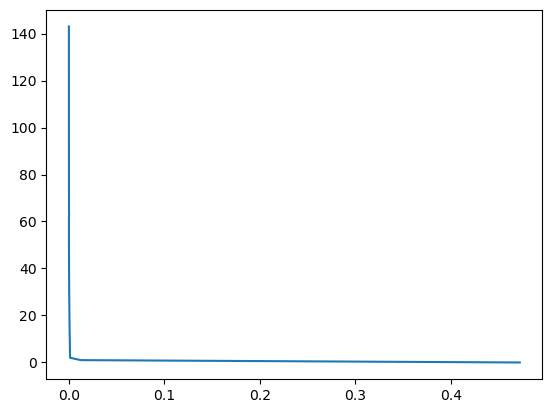

In [24]:
optimal_objective = objective_values[-1]
residuals = np.array(objective_values)-optimal_objective

plt.semilogy(list(range(len(residuals))),residuals)
plt.show()

In [13]:
u, Phi_ks, objective_values = exp.solve(tol=1e-6)

INFO:root:Recompute 1, Psi_k:1.542E-03, Phi_k:4.900E+00, constant:1.292E+04
INFO:root:Recompute 2, Psi_k:7.711E-04, Phi_k:4.900E+00, constant:9.133E+03
INFO:root:Recompute 3, Psi_k:3.855E-04, Phi_k:4.900E+00, constant:6.458E+03
INFO:root:Recompute 4, Psi_k:1.928E-04, Phi_k:4.900E+00, constant:4.566E+03
INFO:root:Recompute 5, Psi_k:9.638E-05, Phi_k:4.900E+00, constant:3.229E+03
INFO:root:Recompute 6, Psi_k:4.819E-05, Phi_k:4.900E+00, constant:2.283E+03
INFO:root:Recompute 7, Psi_k:2.410E-05, Phi_k:4.900E+00, constant:1.614E+03
INFO:root:Recompute 8, Psi_k:1.205E-05, Phi_k:4.900E+00, constant:1.142E+03
INFO:root:Recompute 9, Psi_k:6.024E-06, Phi_k:4.900E+00, constant:8.072E+02
INFO:root:Recompute 10, Psi_k:3.012E-06, Phi_k:4.900E+00, constant:5.708E+02
INFO:root:Recompute 11, Psi_k:1.506E-06, Phi_k:4.900E+00, constant:4.036E+02
INFO:root:Recompute 12, Psi_k:7.530E-07, Phi_k:4.900E+00, constant:2.854E+02
INFO:root:Recompute 13, Psi_k:3.765E-07, Phi_k:4.900E+00, constant:2.018E+02
INFO:roo

KeyboardInterrupt: 

# Test Stochastic

In [3]:
data_path = "../../sisso/src/test/thermal_conductivity_data.csv"
exp = LGCG_stochastic(data_path=data_path, alpha=0.1)

In [4]:
exp.solve(tol=1e-7)

INFO:root:---------------------
INFO:root:---------------------


Time to generate feat space: 262.406 s


INFO:root:0.9755782288434427
INFO:root:1
INFO:root:K []
INFO:root:[0.01650826 0.08398484 0.03875523 0.03877598 0.04318637 0.04194306
 0.04804311 0.06922419 0.08354961 0.11852333 0.04570393 0.04838697
 0.06082152 0.04974988 0.03391667 0.03654056 0.03532187 0.03515929
 0.04248941 0.04185097 0.0362112  0.07187031 0.0379061  0.04252391
 0.03777911 0.13475375 0.12981585 0.11154833 0.34266939 0.21564257
 0.06654163 0.12626913 0.13974483 0.09623659 0.11400463 0.09425901
 0.15303787 0.08798618 0.07927755 0.18412779 0.18997568 0.23295921
 0.08915301 0.20109564 0.13541286 0.09429843 0.07918945 0.06793185
 0.06641488 0.1338539  0.12592129 0.12139781 0.13090409 0.1034475
 0.08834254 0.1011218  0.05419033 0.06345643 0.05942181 0.05300143
 0.0721522  0.09091953 0.08603043 0.10407362 0.1014441  0.065165
 0.19817434 0.27812532 0.24831032 0.06895994 0.13319063 0.11928598
 0.08974987 0.10409334 0.06904784]
/vol/cs-hu/hnatiuar@hu-berlin.de/Dokumente/lazified-generalized-conditional-gradient/lgcg/lgcg_sto

Time to generate feat space: 262.994 s


INFO:root:0.9539958314747843
INFO:root:1
INFO:root:['((omega_Gamma_max / sigma_os) / (Theta_p * L_min_prim))']
INFO:root:2: Phi 3.106E+00, epsilon 6.361E+00, support 1, Psi 5.050E+00
INFO:root:K [[0.01650826 0.08398484 0.03875523 0.03877598 0.04318637 0.04194306
  0.04804311 0.06922419 0.08354961 0.11852333 0.04570393 0.04838697
  0.06082152 0.04974988 0.03391667 0.03654056 0.03532187 0.03515929
  0.04248941 0.04185097 0.0362112  0.07187031 0.0379061  0.04252391
  0.03777911 0.13475375 0.12981585 0.11154833 0.34266939 0.21564257
  0.06654163 0.12626913 0.13974483 0.09623659 0.11400463 0.09425901
  0.15303787 0.08798618 0.07927755 0.18412779 0.18997568 0.23295921
  0.08915301 0.20109564 0.13541286 0.09429843 0.07918945 0.06793185
  0.06641488 0.1338539  0.12592129 0.12139781 0.13090409 0.1034475
  0.08834254 0.1011218  0.05419033 0.06345643 0.05942181 0.05300143
  0.0721522  0.09091953 0.08603043 0.10407362 0.1014441  0.065165
  0.19817434 0.27812532 0.24831032 0.06895994 0.13319063 0.1